In [163]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import importlib
import ml_trading.machine_learning.util

import logging
import datetime, sys, os

date_strftime_format = '%Y-%m-%d %H:%M:%S'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')


from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

logging.basicConfig(stream=sys.stdout, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt=date_strftime_format)

In [164]:
import market_data.util
import market_data.util.time

time_range = market_data.util.time.TimeRange(
    date_str_from='2024-01-01', date_str_to='2025-04-01',
    )


In [166]:
import ml_trading.machine_learning.validation_data
importlib.reload(ml_trading.machine_learning.validation_data)

'''
data_sets = ml_trading.machine_learning.validation_data.create_train_validation_test_splits(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    fixed_window_size = datetime.timedelta(days=150),
    step_size = datetime.timedelta(days=30),
    purge_period = datetime.timedelta(minutes=30),
    embargo_period = datetime.timedelta(days=1),
    split_ratio = [0.8, 0.2, 0.0],
)
#'''


#'''
data_sets = ml_trading.machine_learning.validation_data.create_split_moving_forward(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    initial_training_fixed_window_size = datetime.timedelta(days=150),
    purge_period = datetime.timedelta(minutes=30),
    embargo_period = datetime.timedelta(days=1),
    step_event_size = 300,
    validation_fixed_event_size = 300,
    test_fixed_event_size= 0,
)
#'''


2025-04-11 13:35:18 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/f_add_btc_features-True_f_ema_periods-5_15_30_60_120_240_f_return_periods-1_5_15_30_60_120_f_volatility_windows-240_r_price_col-close_r_threshold-0.05_t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet exists.
2025-04-11 13:35:18 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/f_add_btc_features-True_f_ema_periods-5_15_30_60_120_240_f_return_periods-1_5_15_30_60_120_f_volatility_windows-240_r_price_col-close_r_threshold-0.05_t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/2024-01-02T00:00:00-0500_2024-01-03T00:00:00-0500.parquet exists.
2025-04-11 13:35:18 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/f_add_btc_features-True_f_ema

In [175]:
importlib.reload(ml_trading.machine_learning.util)

<module 'ml_trading.machine_learning.util' from '/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py'>

In [176]:
import ml_trading.models.model

metrics_list = []
all_validation_dfs = []

for i, (train_df, validation_df, test_df) in enumerate(data_sets):
    print(f"\n########################################################")
    print(f"Training model {i+1} of {len(data_sets)}")
    print(f'train: {len(train_df)}\n{train_df.head(1).index}\n{train_df.tail(1).index}')
    print(f'validation: {len(validation_df)}\n{validation_df.head(1).index}\n{validation_df.tail(1).index}')
    #print(f'test: {len(test_df)}\n{test_df.head(1).index}\n{test_df.tail(1).index}')

    model, metrics, validation_y_df = ml_trading.models.model.train_xgboost_model(
        #ml_data_df, 
        train_df=train_df,
        validation_df=validation_df,
        target_column='label_long_tp30_sl30_10m',
        prediction_threshold=0.70)
    metrics_list.append(metrics)
    
    # Add model number for tracking
    validation_y_df['model_num'] = i+1
    all_validation_dfs.append(validation_y_df)

# Print metrics summary
for i, metrics in enumerate(metrics_list):
    print(f"{i+1}, non_zero_accuracy: {metrics['non_zero_accuracy']}")

combined_validation_df = ml_trading.machine_learning.util.combine_validation_dfs(all_validation_dfs)


########################################################
Training model 1 of 26
train: 3708
DatetimeIndex(['2024-01-01 00:28:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-05-30 01:26:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2024-05-31 12:01:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-06-07 15:04:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300
Positive returns: 157 (52.33%)
Negative returns: 98 (32.67%)
Neutral returns: 45 (15.00%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 157
Predicted as positive: 48 (30.57%)
Predicted as neutral: 107 (68.15%)
Predicted as negative: 2 (1.27%)


Total neutral labels: 45
Predicted as positive: 2 (4.44%)
Predicted as neutral: 43 (95.56%)
Predicted as

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 207
Predicted as positive: 13 (6.28%)
Predicted as neutral: 184 (88.89%)
Predicted as negative: 10 (4.83%)


Total neutral labels: 53
Predicted as positive: 0 (0.00%)
Predicted as neutral: 52 (98.11%)
Predicted as negative: 1 (1.89%)


Total negative labels: 40
Predicted as positive: 0 (0.00%)
Predicted as neutral: 39 (97.50%)
Predicted as negative: 1 (2.50%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 13
Actually positive: 13 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 275
Actually positive: 184 (66.91%)
Actually neutral: 52 (18.91%)
Actually negative: 39 (14.18%)


Total negative predictions: 12
Actually positive: 10 (83.33%)
Actually neutral: 1 (8.33%)
Actually negative: 1 (8.33%)

accuracy: 0.22
mae: 0.88
negative_precision: 0.08
negative_recall: 0.03
neutral_precision: 0.19
neutral_recall: 0.98
non_zero_accuracy: 0.56
positive_preci

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 71
Predicted as positive: 1 (1.41%)
Predicted as neutral: 70 (98.59%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 72
Predicted as positive: 0 (0.00%)
Predicted as neutral: 72 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 70 (23.41%)
Actually neutral: 157 (52.51%)
Actually negative: 72 (24.08%)


Total negative predictions: 0
accuracy: 0.53
mae: 0.50
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.53
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision: 1.00
positive_recall: 0.01
r2: -0.02

#################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 123
Predicted as positive: 0 (0.00%)
Predicted as neutral: 123 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 93
Predicted as positive: 0 (0.00%)
Predicted as neutral: 93 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 300
Actually positive: 84 (28.00%)
Actually neutral: 123 (41.00%)
Actually negative: 93 (31.00%)


Total negative predictions: 0
accuracy: 0.41
mae: 0.60
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.41
neutral_recall: 1.00
non_zero_accuracy: 0.00
positive_precision: nan
positive_recall: 0.00
r2: 0.01

########################################################
Training model 9 of 26
train: 3708
DatetimeIndex(['2024-03-29 13:05:00-04:00'], dt

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 100
Predicted as positive: 2 (2.00%)
Predicted as neutral: 97 (97.00%)
Predicted as negative: 1 (1.00%)


Total neutral labels: 129
Predicted as positive: 0 (0.00%)
Predicted as neutral: 129 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 71
Predicted as positive: 0 (0.00%)
Predicted as neutral: 71 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 2
Actually positive: 2 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 297
Actually positive: 97 (32.66%)
Actually neutral: 129 (43.43%)
Actually negative: 71 (23.91%)


Total negative predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)

accuracy: 0.44
mae: 0.58
negative_precision: 0.00
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.67
positive_precisi

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 50
Predicted as positive: 4 (8.00%)
Predicted as neutral: 46 (92.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 126
Predicted as positive: 0 (0.00%)
Predicted as neutral: 126 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 124
Predicted as positive: 1 (0.81%)
Predicted as neutral: 123 (99.19%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 5
Actually positive: 4 (80.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (20.00%)


Total neutral predictions: 295
Actually positive: 46 (15.59%)
Actually neutral: 126 (42.71%)
Actually negative: 123 (41.69%)


Total negative predictions: 0
accuracy: 0.43
mae: 0.62
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.80
positive_precision: 0.80
positive_recall: 0.08
r2: -0.27

###############################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 57
Predicted as positive: 2 (3.51%)
Predicted as neutral: 55 (96.49%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 180
Predicted as positive: 0 (0.00%)
Predicted as neutral: 180 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 63
Predicted as positive: 0 (0.00%)
Predicted as neutral: 63 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 2
Actually positive: 2 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 298
Actually positive: 55 (18.46%)
Actually neutral: 180 (60.40%)
Actually negative: 63 (21.14%)


Total negative predictions: 0
accuracy: 0.61
mae: 0.44
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.60
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision: 1.00
positive_recall: 0.04
r2: -0.07

#################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 154
Predicted as positive: 0 (0.00%)
Predicted as neutral: 154 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 62
Predicted as positive: 0 (0.00%)
Predicted as neutral: 62 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 300
Actually positive: 84 (28.00%)
Actually neutral: 154 (51.33%)
Actually negative: 62 (20.67%)


Total negative predictions: 0
accuracy: 0.51
mae: 0.53
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.51
neutral_recall: 1.00
non_zero_accuracy: 0.00
positive_precision: nan
positive_recall: 0.00
r2: -0.09

########################################################
Training model 19 of 26
train: 3708
DatetimeIndex(['2024-10-14 16:17:00-04:00'], 

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),



########################################################
Training model 20 of 26
train: 3708
DatetimeIndex(['2024-11-06 10:38:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2025-02-03 08:56:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2025-02-04 09:11:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2025-02-12 15:24:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300
Positive returns: 73 (24.33%)
Negative returns: 70 (23.33%)
Neutral returns: 157 (52.33%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 73
Predicted as positive: 0 (0.00%)
Predicted as neutral: 72 (98.63%)
Predicted as negative: 1 (1.37%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 75
Predicted as positive: 0 (0.00%)
Predicted as neutral: 73 (97.33%)
Predicted as negative: 2 (2.67%)


Total neutral labels: 134
Predicted as positive: 0 (0.00%)
Predicted as neutral: 134 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 91
Predicted as positive: 0 (0.00%)
Predicted as neutral: 90 (98.90%)
Predicted as negative: 1 (1.10%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 297
Actually positive: 73 (24.58%)
Actually neutral: 134 (45.12%)
Actually negative: 90 (30.30%)


Total negative predictions: 3
Actually positive: 2 (66.67%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (33.33%)

accuracy: 0.45
mae: 0.58
negative_precision: 0.33
negative_recall: 0.01
neutral_precision: 0.45
neutral_recall: 1.00
non_zero_accuracy: 0.33
positive_precision: nan
positive_recall: 0.00
r2: -0.08

##################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 71
Predicted as positive: 2 (2.82%)
Predicted as neutral: 69 (97.18%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 165
Predicted as positive: 0 (0.00%)
Predicted as neutral: 165 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 64
Predicted as positive: 0 (0.00%)
Predicted as neutral: 62 (96.88%)
Predicted as negative: 2 (3.12%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 2
Actually positive: 2 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 296
Actually positive: 69 (23.31%)
Actually neutral: 165 (55.74%)
Actually negative: 62 (20.95%)


Total negative predictions: 2
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 2 (100.00%)

accuracy: 0.56
mae: 0.45
negative_precision: 1.00
negative_recall: 0.03
neutral_precision: 0.56
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),


In [177]:
# Example usage:
if 'combined_validation_df' in locals():
    # Calculate with different thresholds for comparison
    trade_results_conservative = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.8)
    trade_results = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df)
    trade_results_aggressive = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.5)
#'''


Trade statistics (threshold=0.8):
Total trades: 101
Average return per trade: 0.6238
Win rate: 79.21%, loss: 16.83%, draw: 3.96%
Total return: 63.0000

Trade statistics (threshold=0.7):
Total trades: 172
Average return per trade: 0.5640
Win rate: 75.58%, loss: 19.19%, draw: 5.23%
Total return: 97.0000

Trade statistics (threshold=0.5):
Total trades: 406
Average return per trade: 0.2980
Win rate: 61.58%, loss: 31.77%, draw: 6.65%
Total return: 121.0000


In [178]:
trade_results['date'] = trade_results.index.get_level_values('timestamp').strftime("%Y-%m-%d")

<Axes: xlabel='date'>

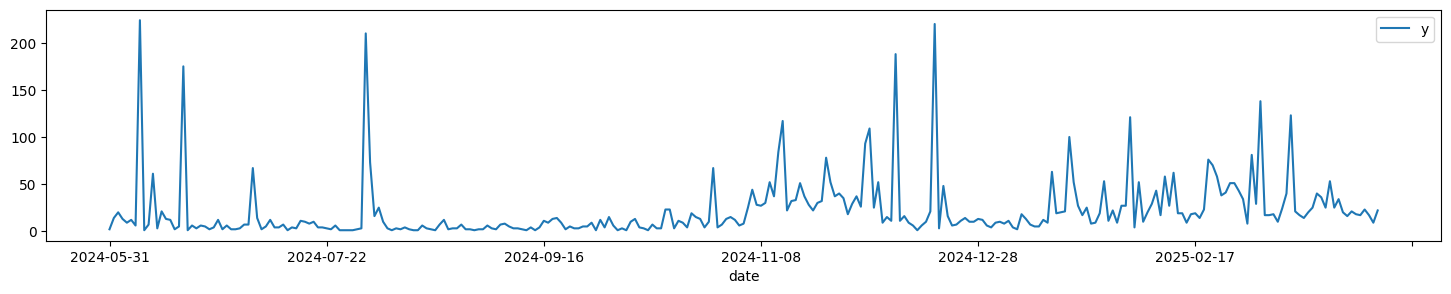

In [179]:
trade_results.groupby(["date"])[["y"]].count().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

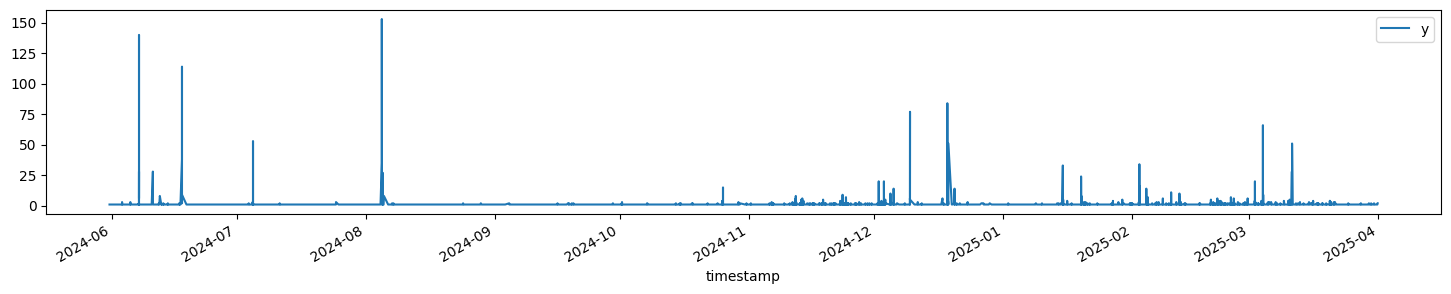

In [172]:
trade_results.groupby(["timestamp"])[["y"]].count().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

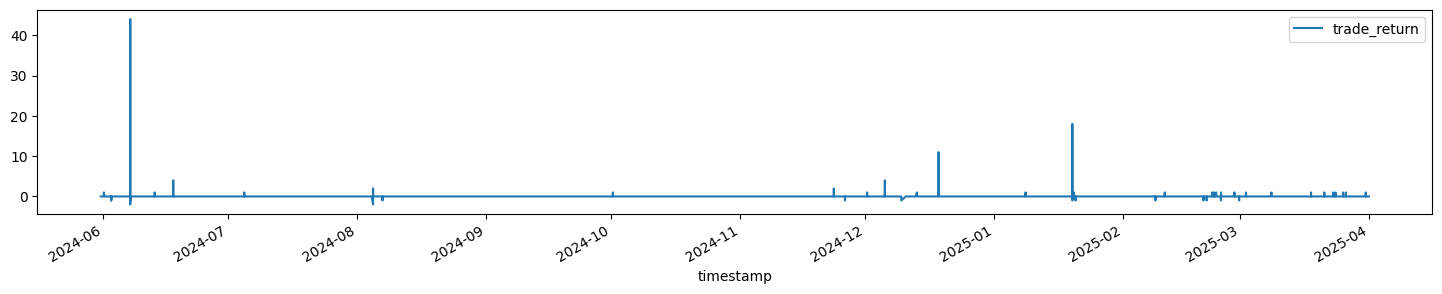

In [173]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

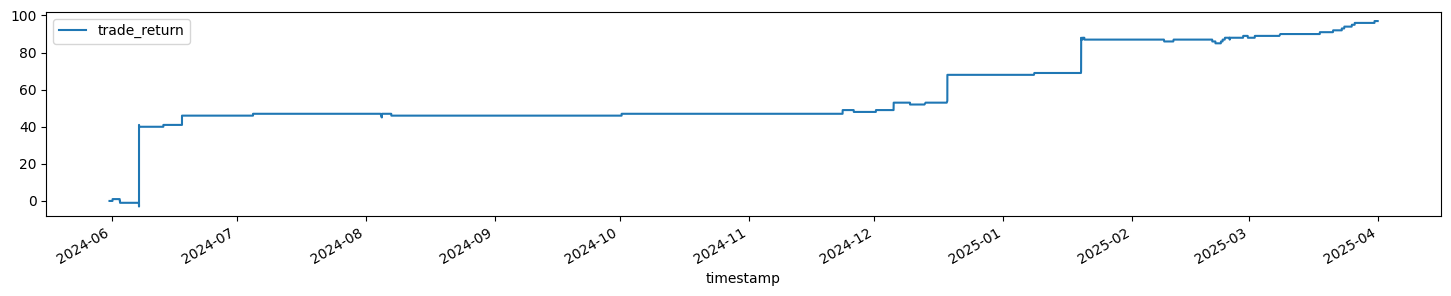

In [180]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

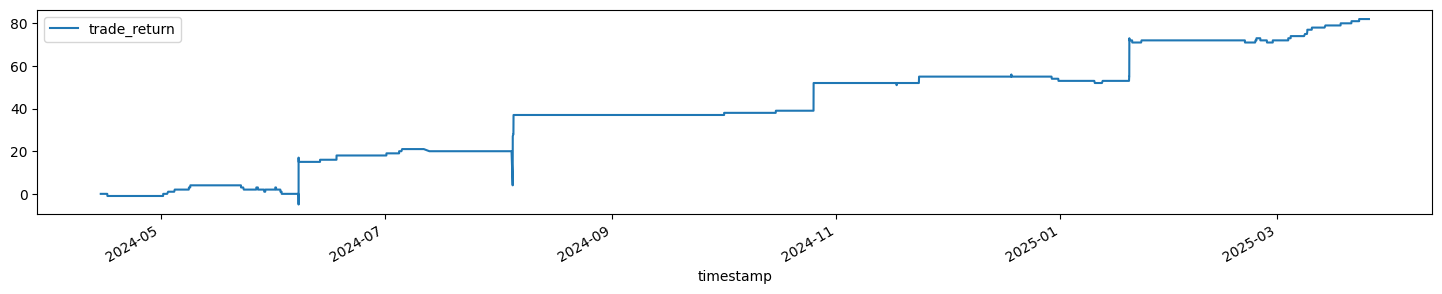

In [162]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))